In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
mus_path = '/SSD/University/'
train = pd.read_csv(mus_path + 'train.csv')
test =  pd.read_csv(mus_path + 'test.csv')
torch.manual_seed(123)

In [2]:
import torch
import numpy as np

enc = { 'mixture':0}
class NoiseSepDataset() : 
    def __init__(self, data ,
                 mus_path =  '/SSD/University/',
                 input_size = 1000 , output_size = 1000) : 
        self.data = data 
        self.mus_path = mus_path + self.data.chunk_path.values
        self.input_size = input_size 
        self.output_size = output_size 
    def __len__(self) : 
        return len(self.data) 
    def _pad_input(self , x ) : 
        size = x.shape[0]
        pad_size = self.input_size - size 
        pad_tensor = torch.tensor([0]*pad_size , dtype =torch.float) 
        pad_tensor = torch.cat([x , pad_tensor] , dim = 0) 
        return pad_tensor.unsqueeze(0)
    def _pad_output(self , x ):
        size = x.shape[0]
        pad_size = self.output_size - size 
        pad_tensor = torch.tensor([0]*pad_size , dtype =torch.float) 
        pad_tensor = torch.cat([x , pad_tensor] , dim = 0) 
        return pad_tensor.unsqueeze(0)
    def __getitem__(self , item) : 
        out = dict() 
        signal = np.load(self.mus_path[item])
        x = torch.tensor(signal[enc['mixture'],:] , dtype = torch.float)
        dist = torch.distributions.normal.Normal(0,0.03)
        out['original'] = self._pad_input(x)
        out['input'] = self._pad_input(x) + dist.sample(self._pad_input(x).shape)
        out['output'] = self._pad_input(x) + dist.sample(self._pad_input(x).shape)
        return out

In [3]:
import matplotlib.pyplot as plt
d = NoiseSepDataset(train)

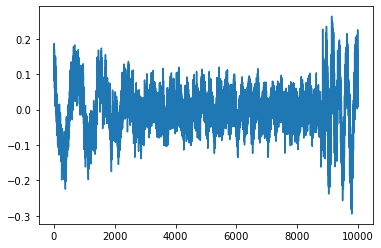

In [4]:
plt.plot(d[0]['input'][0][:10000])

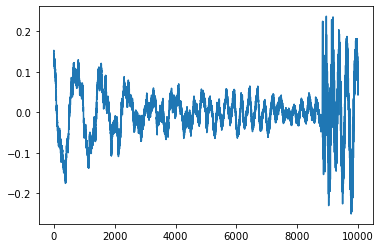

In [5]:
plt.plot(d[0]['original'][0][:10000])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from transformers import AdamW
from tqdm import tqdm



class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count




def train_fn(data_loader, model, loss_fn, optimizer, device, verbose, epoch):
    """
    computes the model training for one epoch
    """
    model.train()
    tr_loss = 0
    counter = 0
    if verbose:
        losses = AverageMeter()
        tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    else:
        tk0 = enumerate(data_loader)
    for bi, d in tk0:
        targets = d["original"]
        targets = targets.to(device, dtype=torch.float)
        input_seq = d["input"].to(device, dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(input_seq)
        loss = loss_fn(
            outputs,
            targets,
        )
        tr_loss += loss.item()
        counter += 1
        loss.backward()
        optimizer.step()
        if verbose:
            losses.update(loss.item(), targets.size(0))
            tk0.set_postfix(loss=losses.avg)
    return tr_loss / counter


def eval_fn(data_loader, model, loss_fn, device, verbose, epoch):
    """
    computes the model evaluation for one epoch
    """
    model.eval()
    fin_loss = 0
    counter = 0
    if verbose:
        losses = AverageMeter()
        tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    else:
        tk0 = enumerate(data_loader)
    with torch.no_grad():
        for bi, d in tk0:
            targets = d["original"]

            targets = targets.to(device, dtype=torch.float)
            input_seq = d["input"].to(device, dtype=torch.float)
            outputs = model(input_seq)
            loss = loss_fn(
                outputs,
                targets,
            )
            fin_loss += loss.item()
            counter += 1
            if verbose:
                losses.update(loss.item(), targets.size(0))
                tk0.set_postfix(loss=losses.avg)
        return fin_loss / counter


def run(
    model,
    train_dataset,
    valid_dataset,
    loss_fn,
    lr,
    EPOCHS,
    TRAIN_BATCH_SIZE,
    VALID_BATCH_SIZE,
    device,
    path,
    verbose=True,
    trial=None,
    log_neptune=False,
    fold=0,
    checkpoint_path=None,
):
    """
    trains a given model for a given number of epochs and paramters
    """
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, shuffle=True, batch_size=TRAIN_BATCH_SIZE, num_workers=96
    )
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=96, shuffle=False
    )

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=5e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.2, patience=3, verbose=verbose
    )
    train_loss = []
    val_loss = []
    best = 50000
    patience = 0
    init_epoch = 0


    for epoch in range(init_epoch, EPOCHS):
        if verbose:
            print(f"--------- Epoch {epoch} ---------")
        tr_loss = train_fn(
            train_data_loader,
            model,
            loss_fn,
            optimizer,
            device,
            verbose,
            epoch,
        )
        train_loss.append(tr_loss)

        if verbose:
            print(f" train_loss  = {tr_loss}")
        val = eval_fn(valid_data_loader, model, loss_fn, device, verbose, epoch)

        val_loss.append(val)
        scheduler.step(val)

        if verbose:
            print(f" val_loss  = {val}")
        if (best-val)/best > 0.005 :
            best = val
            patience = 0
            torch.save(model.state_dict(), path)
        else:
            patience += 1
        if patience > 3:
            print(f"Eraly Stopping on Epoch {epoch}")
            print(f"Best Loss =  {best}")
            break
        if trial is not None:
            trial.report(val, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        if checkpoint_path is not None:
            save_path = os.path.join(checkpoint_path, f"job_num_{epoch+1}.pth")
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler": scheduler,
                    "best": best,
                    "patience": patience,
                },
                save_path,
            )


def predict(model, dataset, device=torch.device("cuda:3"), is_diff=False):
    """
    computes the prediction a given model and data
    """
    model.eval()
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, num_workers=4, shuffle=False
    )
    losses = AverageMeter()
    rmse = AverageMeter()
    tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    with torch.no_grad():
        for bi, d in tk0:
            original = d["original"]
            input_seq = d["input"].to(device, dtype=torch.float)
            outputs = model(input_seq)
            if bi == 0:
                out = outputs
                originals = original
                input_seqs = input_seq
            else:
                out = torch.cat([out, outputs], dim=2)
                originals = torch.cat([originals, original], dim=2)
                input_seqs = torch.cat([input_seqs, input_seq], dim=2)

    return out.cpu().detach().numpy(),originals.cpu().numpy(),input_seqs.cpu().numpy()

In [7]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        x_reshape = x.contiguous().view(-1, x.size(-1))
        y = self.module(x_reshape)
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))
        else:
            y = y.view(-1, x.size(1), y.size(-1))
        return y

    def forward_masks(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        x_reshape = x.contiguous().view(-1, x.size(-1))
        y = self.forward_masks(x_reshape)
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))
        else:
            y = y.view(-1, x.size(1), y.size(-1))
        return y


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from utils import *
class Encoder(nn.Module):
    """Estimation of the nonnegative mixture weight by a 1-D conv layer.
    """
    def __init__(self, L, N):
        super(Encoder, self).__init__()
        # Hyper-parameter
        self.L, self.N = L, N
        # Components
        # 50% overlap (because of stride)
        """ take a seq and maps it into N chunks of len K """
        self.conv1d_U = nn.Conv1d(1, N, kernel_size=L, stride=L // 2, bias=False)

    def forward(self, mixture):
        """
        Args:
            mixture: [M, T], M is batch size, T is #samples
        Returns:
            mixture_w: [M, N, K], where K = (T-L)/(L/2)+1 = 2T/L-1
        """
        mixture_w = F.relu(self.conv1d_U(mixture))  # [M, N, K]
        return mixture_w
    
    
class TemporalConvNet(nn.Module):
    def __init__(self, N, B, H, P, X, R, C, norm_type="gLN", causal=False,
                 mask_nonlinear='relu'):
        """
        Args:
            N: Number of filters in autoencoder
            B: Number of channels in bottleneck 1 × 1-conv block
            H: Number of channels in convolutional blocks
            P: Kernel size in convolutional blocks
            X: Number of convolutional blocks in each repeat
            R: Number of repeats
            C: Number of speakers
            norm_type: BN, gLN, cLN
            causal: causal or non-causal
            mask_nonlinear: use which non-linear function to generate mask
        """
        super(TemporalConvNet, self).__init__()
        # Hyper-parameter
        self.C = C
        self.mask_nonlinear = mask_nonlinear
        # Components
        # [M, N, K] -> [M, N, K]
        layer_norm = ChannelwiseLayerNorm(N)
        # [M, N, K] -> [M, B, K]
        bottleneck_conv1x1 = nn.Conv1d(N, B, 1, bias=False)
        # [M, B, K] -> [M, B, K]
        repeats = []
        for r in range(R):
            blocks = []
            for x in range(X):
                dilation = 2**x
                padding = (P - 1) * dilation if causal else (P - 1) * dilation // 2
                blocks += [TemporalBlock(B, H, P, stride=1,
                                         padding=padding,
                                         dilation=dilation,
                                         norm_type=norm_type,
                                         causal=causal)]
            repeats += [nn.Sequential(*blocks)]
        temporal_conv_net = nn.Sequential(*repeats)
        # [M, B, K] -> [M, C*N, K]
        mask_conv1x1 = nn.Conv1d(B, C*N, 1, bias=False)
        # Put together
        self.network = nn.Sequential(layer_norm,
                                     bottleneck_conv1x1,
                                     temporal_conv_net,
                                     mask_conv1x1)

    def forward(self, mixture_w):
        """
        Keep this API same with TasNet
        Args:
            mixture_w: [M, N, K], M is batch size
        returns:
            est_mask: [M, C, N, K]
        """
        M, N, K = mixture_w.size()
        score = self.network(mixture_w)  # [M, N, K] -> [M, C*N, K]
        score = score.view(M, self.C, N, K) # [M, C*N, K] -> [M, C, N, K]
        if self.mask_nonlinear == 'softmax':
            est_mask = F.softmax(score, dim=1)
        elif self.mask_nonlinear == 'relu':
            est_mask = F.relu(score)
        else:
            raise ValueError("Unsupported mask non-linear function")
        return est_mask
    
    
class Decoder(nn.Module):
    def __init__(self, N, L):
        super(Decoder, self).__init__()
        # Hyper-parameter
        self.N, self.L = N, L
        # Components
        self.basis_signals = nn.Linear(N, L, bias=False)
    def forward(self, mixture_w, est_mask,device):
        """
        Args:
            mixture_w: [M, N, K]
            est_mask: [M, C, N, K]
        Returns:
            est_source: [M, C, T]
        """
        # D = W * M
        source_w = torch.unsqueeze(mixture_w, 1) * est_mask  # [M, C, N, K]
        source_w = torch.transpose(source_w, 2, 3) # [M, C, K, N]
        # S = DV
        est_source = self.basis_signals(source_w)  # [M, C, K, L]
        
        est_source = overlap_and_add(est_source, self.L//2,device) # M x C x T
        return est_source
    
    
class Full_Model(nn.Module):
    def __init__(self, params):
        """
        Args:
            N: Number of filters in autoencoder
            L: Length of the filters (in samples)
            B: Number of channels in bottleneck 1 × 1-conv block
            H: Number of channels in convolutional blocks
            P: Kernel size in convolutional blocks
            X: Number of convolutional blocks in each repeat
            R: Number of repeats
            C: Number of speakers
            norm_type: BN, gLN, cLN
            causal: causal or non-causal
            mask_nonlinear: use which non-linear function to generate mask
        """
        super(Full_Model, self).__init__()
        # Hyper-parameter
        self.N, self.L, self.B, self.H, self.P, self.X, self.R, self.C = (params['n_filters_encoder'], params['length_of_filters'], params["n_filters_bottleneck 1x1 conv"],
                                                                          params["n_channels _cvblocks"], params['Kernel_size_cvblocks'], params['n_cvblocks_each_rep'],
                                                                          params['n_blocks'], params['number_of_sources'])
        self.norm_type = params['norm_type']
        self.causal = params['causal']
        self.mask_nonlinear = params['mask_nonlinear']
        self.device = params['device']
        # Components
        self.encoder = Encoder(self.L, self.N)
        self.separator = TemporalConvNet(self.N, self.B, self.H, self.P, self.X, self.R, self.C, self.norm_type, self.causal, self.mask_nonlinear)
        self.decoder = Decoder(self.N, self.L)
        # init
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)

    def forward(self, mixture):
        """
        Args:
            mixture: [M, T], M is batch size, T is #samples
        Returns:
            est_source: [M, C, T]
        """
        mixture_w = self.encoder(mixture)
        est_mask = self.separator(mixture_w)
        est_source = self.decoder(mixture_w, est_mask,self.device)

        # T changed after conv1d in encoder, fix it here
        T_origin = mixture.size(-1)
        T_conv = est_source.size(-1)
        est_source = F.pad(est_source, (0, T_origin - T_conv))
        return est_source

    @classmethod
    def load_model(cls, path):
        # Load to CPU
        package = torch.load(path, map_location=lambda storage, loc: storage)
        model = cls.load_model_from_package(package)
        return model

    @classmethod
    def load_model_from_package(cls, package):
        model = cls(package['N'], package['L'], package['B'], package['H'],
                    package['P'], package['X'], package['R'], package['C'],
                    norm_type=package['norm_type'], causal=package['causal'],
                    mask_nonlinear=package['mask_nonlinear'])
        model.load_state_dict(package['state_dict'])
        return model

    @staticmethod
    def serialize(model, optimizer, epoch, tr_loss=None, cv_loss=None):
        package = {
            # hyper-parameter
            'N': model.N, 'L': model.L, 'B': model.B, 'H': model.H,
            'P': model.P, 'X': model.X, 'R': model.R, 'C': model.C,
            'norm_type': model.norm_type, 'causal': model.causal,
            'mask_nonlinear': model.mask_nonlinear,
            # state
            'state_dict': model.state_dict(),
            'optim_dict': optimizer.state_dict(),
            'epoch': epoch
        }
        if tr_loss is not None:
            package['tr_loss'] = tr_loss
            package['cv_loss'] = cv_loss
        return package
    
class ConvTasNet:

    def __init__(self, params):
        self.name = "ConvTasNet"
        self.model = nn.DataParallel(Full_Model(params))
        self.model = self.model.to(params["device"])
        self.params = params

    def _create_dataset(self, dataset):
        return NoiseSepDataset(
            dataset,
        )

    def _model_trainer(self, model, train_dataset, valid_dataset, params):
        return run(
            model,
            train_dataset,
            valid_dataset,
            self.params["loss_fn"],
            params["lr"],
            params["epochs"],
            params["batch_size"],
            params["batch_size"],
            params["device"],
            params["save_path"],
            self.params["verbose"],
            checkpoint_path = params['checkpoint_path']
            
        )

    def train(self, train_dataset, valid_dataset, params):
        train_data = self._create_dataset(train_dataset)
        valid_data = self._create_dataset(valid_dataset)

        if params["verbose"]:
            print("Training Model ...")
            
        if params['checkpoint_path'] is not None : 
            save_path = os.path.join(params['checkpoint_path'] , 'job_num_0.pth')
            torch.save({"epoch" : 0 } , save_path)
            
        self._model_trainer(self.model, train_data, valid_data, params)

    def predict(self, dataset):
        test_dataset = self._create_dataset(dataset)
        pred = predict(self.model, test_dataset)
        return pred
        
    def save(self,path):
            torch.save({'model':self.model.state_dict(),
                        },path)
    
    def load(self,path):
        state=torch.load(path)
        self.model.load_state_dict(state['model'])


In [10]:
import torch
params = dict()
params['number_of_sources'] = 1 #C
params['input_seq_len'] = 88200 #T
params['n_filters_encoder'] = 512 #N
params['length_of_filters'] = 300 #L

params["n_filters_bottleneck 1x1 conv"] = 128 #B
params["n_channels _cvblocks"] = 512 #H
params['Kernel_size_cvblocks'] = 3 #P
params['n_cvblocks_each_rep'] = 8 #X
params['n_blocks'] =3 #R
params['norm_type'] = "gLN"
params['causal'] = False
params['mask_nonlinear'] = 'softmax'


params['batch_size'] = 256
params['epochs'] = 100
params['lr'] = 5e-3
params['device'] = torch.device('cuda:2')
params['verbose'] = True
params['loss_fn'] = torch.nn.L1Loss()#torch.nn.SmoothL1Loss()#
params['save_path'] = 'noise2noiseoriginal.pth'
params['checkpoint_path'] = None
model = ConvTasNet(params)

In [11]:
2*params['input_seq_len']/params['length_of_filters']-1

587.0

In [12]:
model.model.load_state_dict(torch.load('noise2noiseoriginal.pth'))

FileNotFoundError: [Errno 2] No such file or directory: 'noise2noiseoriginal.pth'

In [28]:
model.train(train,test,params)

Training Model ...
--------- Epoch 0 ---------


100%|██████████| 45/45 [00:26<00:00,  1.71it/s, loss=0.03]  

 train_loss  = 0.029876316462953887



100%|██████████| 25/25 [00:08<00:00,  2.93it/s, loss=0.0204]

 val_loss  = 0.020437516421079636
--------- Epoch 1 ---------



100%|██████████| 45/45 [00:25<00:00,  1.77it/s, loss=0.0179]

 train_loss  = 0.017901755000154177



100%|██████████| 25/25 [00:08<00:00,  3.01it/s, loss=0.0182]

 val_loss  = 0.018228757455945016
--------- Epoch 2 ---------



100%|██████████| 45/45 [00:25<00:00,  1.78it/s, loss=0.0164]

 train_loss  = 0.016383032728400495



100%|██████████| 25/25 [00:08<00:00,  3.07it/s, loss=0.0162]

 val_loss  = 0.016240967065095903
--------- Epoch 3 ---------



100%|██████████| 45/45 [00:24<00:00,  1.86it/s, loss=0.0161]

 train_loss  = 0.016138456037475005



100%|██████████| 25/25 [00:08<00:00,  3.02it/s, loss=0.0162]

 val_loss  = 0.01618445374071598
--------- Epoch 4 ---------



100%|██████████| 45/45 [00:25<00:00,  1.80it/s, loss=0.0157]

 train_loss  = 0.015642082939545315



100%|██████████| 25/25 [00:08<00:00,  3.03it/s, loss=0.0163]

 val_loss  = 0.016289120987057686
--------- Epoch 5 ---------



100%|██████████| 45/45 [00:24<00:00,  1.80it/s, loss=0.0154]

 train_loss  = 0.015386600668231646



100%|██████████| 25/25 [00:08<00:00,  3.01it/s, loss=0.0163]

 val_loss  = 0.016333133056759833
--------- Epoch 6 ---------



100%|██████████| 45/45 [00:25<00:00,  1.73it/s, loss=0.0151]

 train_loss  = 0.015094267597628965



100%|██████████| 25/25 [00:08<00:00,  3.07it/s, loss=0.0159]

 val_loss  = 0.01592629637569189
--------- Epoch 7 ---------



100%|██████████| 45/45 [00:24<00:00,  1.81it/s, loss=0.0147]

 train_loss  = 0.01473785951319668



100%|██████████| 25/25 [00:08<00:00,  2.78it/s, loss=0.0157]

 val_loss  = 0.01570251937955618
--------- Epoch 8 ---------



100%|██████████| 45/45 [00:24<00:00,  1.85it/s, loss=0.0146]

 train_loss  = 0.014605555186669032



100%|██████████| 25/25 [00:08<00:00,  2.94it/s, loss=0.0151]

 val_loss  = 0.015088312402367592
--------- Epoch 9 ---------



100%|██████████| 45/45 [00:25<00:00,  1.79it/s, loss=0.0145]

 train_loss  = 0.014498621949719058



100%|██████████| 25/25 [00:08<00:00,  3.01it/s, loss=0.0158]

 val_loss  = 0.015835291221737862
--------- Epoch 10 ---------



100%|██████████| 45/45 [00:24<00:00,  1.82it/s, loss=0.0146]

 train_loss  = 0.014619967134462463



100%|██████████| 25/25 [00:08<00:00,  2.91it/s, loss=0.0156]

 val_loss  = 0.015566438846290111
--------- Epoch 11 ---------



100%|██████████| 45/45 [00:24<00:00,  1.83it/s, loss=0.0143]

 train_loss  = 0.014297092457612355



100%|██████████| 25/25 [00:08<00:00,  3.02it/s, loss=0.0151]

 val_loss  = 0.015114493407309056
--------- Epoch 12 ---------



100%|██████████| 45/45 [00:24<00:00,  1.82it/s, loss=0.0143]

 train_loss  = 0.014339450043108729



100%|██████████| 25/25 [00:08<00:00,  2.80it/s, loss=0.0149]

 val_loss  = 0.01491704411804676
--------- Epoch 13 ---------



100%|██████████| 45/45 [00:24<00:00,  1.83it/s, loss=0.0141]

 train_loss  = 0.014091018421782387



100%|██████████| 25/25 [00:08<00:00,  3.08it/s, loss=0.0157]

 val_loss  = 0.015699120238423347
--------- Epoch 14 ---------



100%|██████████| 45/45 [00:24<00:00,  1.86it/s, loss=0.0142]

 train_loss  = 0.014151896225909393



100%|██████████| 25/25 [00:08<00:00,  2.88it/s, loss=0.0146]

 val_loss  = 0.014617609120905399
--------- Epoch 15 ---------



100%|██████████| 45/45 [00:25<00:00,  1.79it/s, loss=0.0139]

 train_loss  = 0.013925718371238974



100%|██████████| 25/25 [00:08<00:00,  3.07it/s, loss=0.0148]

 val_loss  = 0.014830944500863552
--------- Epoch 16 ---------



100%|██████████| 45/45 [00:24<00:00,  1.82it/s, loss=0.014] 

 train_loss  = 0.01396598828335603



100%|██████████| 25/25 [00:08<00:00,  2.94it/s, loss=0.0147]

 val_loss  = 0.014660142101347447
--------- Epoch 17 ---------



100%|██████████| 45/45 [00:25<00:00,  1.74it/s, loss=0.0138]

 train_loss  = 0.013832902080482906



100%|██████████| 25/25 [00:08<00:00,  3.01it/s, loss=0.0148]

 val_loss  = 0.014759231433272362
--------- Epoch 18 ---------



100%|██████████| 45/45 [00:25<00:00,  1.76it/s, loss=0.014] 

 train_loss  = 0.013975936422745387



100%|██████████| 25/25 [00:08<00:00,  3.07it/s, loss=0.0145]

 val_loss  = 0.014532060995697975
--------- Epoch 19 ---------



100%|██████████| 45/45 [00:24<00:00,  1.82it/s, loss=0.0139]

 train_loss  = 0.013888736648692026



100%|██████████| 25/25 [00:08<00:00,  3.12it/s, loss=0.0146]

 val_loss  = 0.014626184590160846
--------- Epoch 20 ---------



100%|██████████| 45/45 [00:24<00:00,  1.86it/s, loss=0.0139]

 train_loss  = 0.013890496372348732



100%|██████████| 25/25 [00:08<00:00,  2.89it/s, loss=0.0145]

 val_loss  = 0.014473001584410667
--------- Epoch 21 ---------



100%|██████████| 45/45 [00:24<00:00,  1.84it/s, loss=0.0138]

 train_loss  = 0.013784830872383382



100%|██████████| 25/25 [00:08<00:00,  3.01it/s, loss=0.0145]

 val_loss  = 0.01453465074300766
--------- Epoch 22 ---------



100%|██████████| 45/45 [00:24<00:00,  1.83it/s, loss=0.0138]

 train_loss  = 0.013843690148658223



100%|██████████| 25/25 [00:08<00:00,  2.83it/s, loss=0.0146]

 val_loss  = 0.014640718214213849
Eraly Stopping on Epoch 22
Best Loss =  0.014532060995697975


In [29]:
out,origin, inp = model.predict(train[:2])

100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


In [30]:
out[0,:].shape

(1, 176400)

In [34]:
import museval
from functools import partial
import pandas as pd
import numpy as np

class Evaluation:
    def __init__(self,data,songs_names,model):
        self.data = data
        self.songs_names=songs_names
        self.model = model
        
    def get_song(self,x,name):
        if name in x:
            return  1
        else:
            return 0
        
    def sort(self,x):
        return int(x.split('_')[-1].split('.')[0])

    def construct_song_df(self,song_name):
        get_song_func = partial(self.get_song,name=song_name)
        df = self.data.copy()
        df['song'] = df['chunk_path'].apply(get_song_func)
        df=df[df['song']==1].copy()
        df['chunk_number']=df['chunk_path'].apply(self.sort)
        df.sort_values('chunk_number',inplace=True, ascending=True)
        return df
    
    def calculate_metrics_one_song(self,song_name):
        self.model.model.eval()
        df = self.construct_song_df(song_name)
        predictions, target, inp = self.model.predict(df)
        print(inp.shape)
        target = target.reshape(1,target.shape[2],1)
        predictions =predictions.reshape(1,predictions.shape[2],1)
        inp =inp.reshape(1,inp.shape[2],1)
        SDR, ISR, SIR, SAR, _ = museval.metrics.bss_eval(
                target, inp,window=np.inf
            )
        return SDR, ISR, SIR, SAR
        
    def calculate_metrics(self):
        metrics = dict()
        for song_name in self.songs_names:
            try:
                SDR, ISR, SIR, SAR  = self.calculate_metrics_one_song(song_name)
                metrics[song_name] = {
                    "SDR": SDR.item(),
                    "ISR": ISR.item(),
                    "SIR": SIR.item(),
                    "SAR": SAR.item(),
                }
            except:
                continue
                
        for metric in ['SDR','ISR','SIR','SAR']:
            try:
                mean = np.mean([metrics[i][metric][0] for i in self.songs_names])
                metrics[f'mean_{metric}'] = mean
            except:
                continue
                
        return metrics

In [35]:
import museval
from functools import partial
import pandas as pd
import numpy as np

def get_song(x,name):
        if name in x:
            return  1
        else:
            return 0
def sort(x):
    return int(x.split('_')[-1].split('.')[0])

def construct_song_df(song_name,data):
    get_song_func = partial(get_song,name=song_name)
    df = data.copy()
    df['song'] = df['chunk_path'].apply(get_song_func)
    df=df[df['song']==1].copy()
    df['chunk_number']=df['chunk_path'].apply(sort)
    df.sort_values('chunk_number',inplace=True, ascending=True)
    return df

def calculate_metrics_one_song(song_name,data):
    model.model.eval()
    df = construct_song_df(song_name,data)
    predictions, target, inp = model.predict(df)
    target = target.reshape(1,target.shape[2],1)
    predictions =predictions.reshape(1,predictions.shape[2],1)
    inp =inp.reshape(1,inp.shape[2],1)
    SDR, ISR, SIR, SAR, _ = museval.metrics.bss_eval(
            target, predictions,window=np.inf
        )
    return SDR, ISR, SIR, SAR
calculate_metrics_one_song(f'track_{0}_',test)

100%|██████████| 125/125 [00:05<00:00, 22.35it/s]


(array([[16.21753466]]),
 array([[22.0185283]]),
 array([[inf]]),
 array([[17.34447739]]))

In [ ]:
from evaluation_class import *
names = [f'track_{i}_' for i in range(60)]
evaluate = Evaluation(test,names,model)
metrics= evaluate.calculate_metrics()

 87%|████████▋ | 95/109 [00:04<00:01, 13.24it/s]

In [ ]:
import json
with open('metrics_Noise2Clean_CVTNet.json', 'w') as fp:
    json.dump(metrics, fp)

In [19]:
import json
with open('metrics_Noise2Noise_CVTNet.json', 'w') as fp:
    json.dump(metrics, fp)

In [22]:
metrics

{'track_0_': {'SDR': 16.335758900916765,
  'ISR': 22.92989675335644,
  'SIR': inf,
  'SAR': 17.248200608031865},
 'track_1_': {'SDR': 14.916396731107817,
  'ISR': 19.10030789839197,
  'SIR': inf,
  'SAR': 16.742087972129845},
 'track_2_': {'SDR': 17.73333641640578,
  'ISR': 23.557454136791286,
  'SIR': inf,
  'SAR': 18.883318646898807},
 'track_3_': {'SDR': 16.095077945508592,
  'ISR': 21.713398344664,
  'SIR': inf,
  'SAR': 17.386080666223116},
 'track_4_': {'SDR': 14.819380300990543,
  'ISR': 18.68476047256109,
  'SIR': inf,
  'SAR': 16.885772957106497},
 'track_5_': {'SDR': 16.639654773411806,
  'ISR': 25.81465240043114,
  'SIR': inf,
  'SAR': 17.041012721308977},
 'track_6_': {'SDR': 16.45061865440509,
  'ISR': 21.78512694819804,
  'SIR': inf,
  'SAR': 17.800041789115863},
 'track_7_': {'SDR': 15.393425334445547,
  'ISR': 19.151737955333314,
  'SIR': inf,
  'SAR': 17.52976183733676},
 'track_8_': {'SDR': 16.77586543085659,
  'ISR': 21.42828675656197,
  'SIR': inf,
  'SAR': 18.34446

In [28]:
np.mean([metrics[i]['SDR'] for i in names[:50]])

15.803204570558371